# Polar coordinates

In [1]:
include("smij-functions.jl");

We already discussed how to discretize polar coordinates using finite differences. Trefethen chooses to use $r>0$ and $\theta\in[0,2π]$, while we used $-1<r<1$ and $\theta\in[0,\pi]$, and we have $r$ varying down rows, while he puts $r$ varying along columns. The resulting details are different, but similar.

In [2]:
using SparseArrays

function polarlap(nr,nθ)
    @assert isodd(nr)
    ⊗ = kron
    Dr, r = cheb(nr)
    Drr = Dr^2
    S = spdiagm(1 ./r)
    θ,Dθ,Dθθ = trig(2nθ)
    Q₁₁,Q₁₂ = Dθθ[1:nθ,1:nθ], Dθθ[nθ+1:2nθ,1:nθ]
    return r, θ[1:nθ], I(nθ)⊗(Drr + S*Dr) + Q₁₁⊗S.^2 + Q₁₂⊗reverse(S.^2,dims=2)
end

polarlap (generic function with 1 method)

We can use the polar Laplacian to find eigenvalues and eigenfunctions on the disk.

### p28: eigenmodes of Laplacian on the disk (compare p22)

In [3]:
N, M = 25, 20
r, θ, L = polarlap(N,M)

bdy = falses(N+1, M)
bdy[[1, N+1], :] .= true
L[vec(bdy),:] .= I((N+1) * M)[vec(bdy),:]
P = diagm(vec(.!bdy))

# Compute four eigenmodes:
index = [1, 3, 6, 10]
λ, V = eigen(-L, P, sortby=abs)
V = V[:, isfinite.(λ)]
λ = sqrt.(filter(isfinite,λ) / λ[1]);

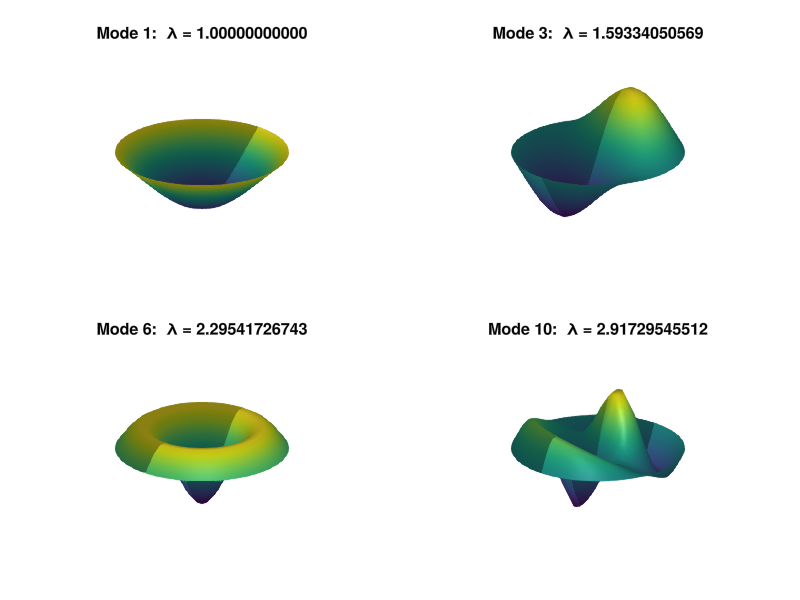

In [4]:
# Plot eigenmodes:
using GLMakie, PyFormattedStrings

X = [r*cos(θ) for r in r, θ in θ]
Y = [r*sin(θ) for r in r, θ in θ]
fig = Figure()
ax = vec([ Axis3(fig[j,i]) for i in 1:2, j in 1:2 ])
extend(Z) = [Z reverse(Z[:, 1])]
for (ax,i) in zip(ax,index)
    U = reshape(V[:, i], N+1, M)
    U = normalize(U, Inf)
    surface!(ax, extend(X), extend(Y), extend(U))
    ax.title = f"Mode {i}:  λ = {λ[i]:.11f}"
    limits!(ax,-1.05, 1.05,-1.05, 1.05, -1.05, 1.05)
end
hidespines!.(ax)
hidedecorations!.(ax)
fig

In [5]:
isreal(U)

LoadError: UndefVarError: U not defined

Or we can solve boundary-value problems. To avoid a crude-looking plot that belies the true underlying accuracy, we can interpolate from the solution grid to a finer one. This entails trig interpolation along the rows, where the row at $r$ is continued by the row at $-r$ in order to create a periodic function of $\theta$, along with ordinary Chebyshev interpolation along the columns. 

### p29: solve Poisson equation on the unit disk

The function $f$ had to be changed from Trefethen. As written there, it is not equivalent on our discretization choice of $[-1,1]\times [0,\pi]$.

In [6]:
N, M = 35, 30
r, θ, L = polarlap(N, M)
f = [ -r^2 * sin(2θ)^4 - 2sin(4θ) * cos(θ)^2 for r in r, θ in θ ]


bdy = falses(N+1, M)
bdy[[1, N+1], :] .= true
L[vec(bdy),:] .= I((N+1) * M)[vec(bdy),:]
f[bdy] .= 0

# Right-hand side and solution for u:
u = L \ vec(f);

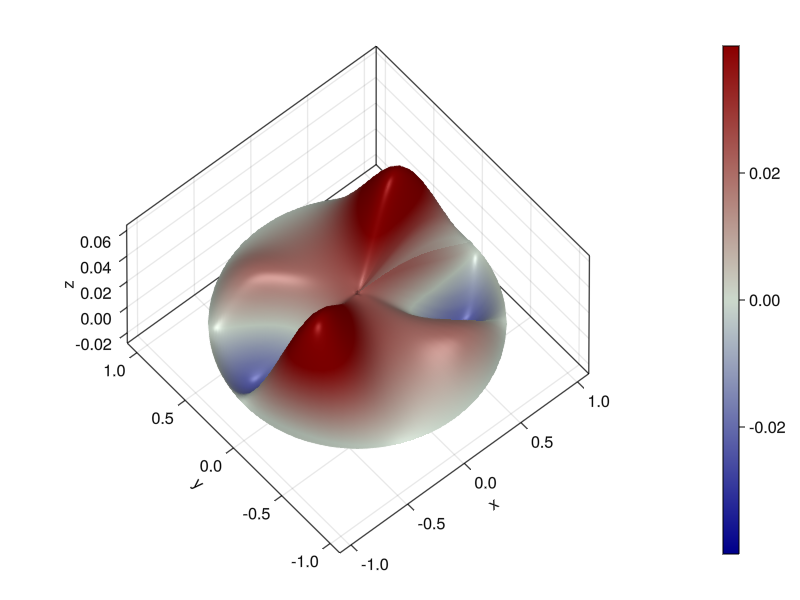

In [7]:
# Reshape results onto 2D grid and plot them:
U = reshape(u, N+1, M)
NN, MM = 51, 80
rr = range(0, 1, NN)
θθ = range(0, 2π, MM)
VV = zeros(N+1, MM)
for i in axes(U, 1)
    v = [U[i,:]; U[N+2-i,:]]
    VV[i,:] .= triginterp(v).(θθ)
end
UU = zeros(NN, MM)
for j in axes(VV,2)
    UU[:,j] .= polyinterp(r,VV[:,j]).(rr)
end

XX = [ r*cos(θ) for r in rr, θ in θθ ]
YY = [ r*sin(θ) for r in rr, θ in θθ ]
fig = Figure()
ax = Axis3(fig[1, 1], elevation=1.0, 
    xlabel="x", ylabel="y", zlabel="z")
surf = surface!(XX, YY, UU, colormap=:bluesreds, colorrange=(-0.04,0.04))
Colorbar(fig[1,2],surf)
fig